In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

fpath = '../example/data/data_processed_1prod_full.json'
df = pd.read_json(fpath, lines=True)
docs = df['reviewText'].astype(str)

Arguments are devided into chunks by dependency parsing.

The current rule is to split sentences by conjunctions connecting two verb phrases.

In [2]:
from orangecontrib.argument.miner.topic import ArguTopic, chunker

chunks = chunker(docs)
chunks.head()

/home/jqi/Workspace/orange3-argument/venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jqi/Workspace/orange3-argument/venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jqi/Workspace/orange3-argument/venv/lib/python3.10

,doc_id,chunk
0,0,I always get a half size up in my tennis shoes .
1,0,For some reason these feel to big in the heel ...
2,1,walked 3 hours with no problem
3,1,Put them on and !
4,1,Love them !


In [3]:
# Chunking example
print(docs.loc[282])
chunks[chunks["doc_id"] == 282]

Good for non-aerobic workout. Mesh was very comfortable but no support for lateral movrment.


,doc_id,chunk
840,282,Good for non - aerobic workout .
841,282,no support for lateral movrment
842,282,Mesh was very comfortable but .


In [4]:
topic_model = ArguTopic()

In [5]:
topics, probs = topic_model.fit_transform_reduce_outliers(chunks['chunk'])

In [7]:
chunks['chunk_rank'] = topic_model.get_doc_ranks(chunks["chunk"])
chunks.head()

,doc_id,chunk,chunk_rank
0,0,I always get a half size up in my tennis shoes .,0.954066
1,0,For some reason these feel to big in the heel ...,0.965786
2,1,walked 3 hours with no problem,0.949656
3,1,Put them on and !,0.979372
4,1,Love them !,0.881731


Decisions made:
- outliers are reduced as much as possible without affecting the topic modeling result too much
- lemmatization is absent but will be added
- POS as representation model, see patterns in the source code.

In [7]:
topic_model.get_topic_table()

,Topic,Count,Name,keyword,keyword_scores
0,-1,27,-1_excelente_happened_crosstrainers_intended,"[excelente, happened, crosstrainers, intended,...","[1.1161912014785589, 0.9126471656932069, 0.912..."
1,0,115,0_true_expected_fit_fits,"[true, expected, fit, fits, glove, perfect, qu...","[0.4748237829513729, 0.44316708407464783, 0.43..."
2,1,98,1_sneakers_insole_breathable_training,"[sneakers, insole, breathable, training, runni...","[0.3167925914515192, 0.282263789047336, 0.2822..."
3,2,89,2_half_ordered_order_size,"[half, ordered, order, size, big, large, usual...","[0.46720440366916216, 0.44428569020814185, 0.4..."
4,3,73,3_favorite_turned_liked_absolute,"[favorite, turned, liked, absolute, love, easy...","[0.6941245718589287, 0.6189241039805948, 0.593..."
5,4,63,4_issues_roomy_cushion_bad,"[issues, roomy, cushion, bad, attractive, styl...","[0.5020137385990797, 0.4666332521585905, 0.460..."
6,5,43,5_lightweight_paper_minimalist_held,"[lightweight, paper, minimalist, held, light, ...","[0.6236381038603368, 0.6123515611372359, 0.612..."
7,6,43,6_mesh_felt_summer_comfy,"[mesh, felt, summer, comfy, tight, requires, s...","[0.6627948941118658, 0.5411697648986926, 0.541..."
8,7,46,7_hurt_pain_problems_hip,"[hurt, pain, problems, hip, weird, discomfort,...","[0.5751447174832408, 0.5556388510582352, 0.479..."
9,8,49,8_everyday_use_class_zumba,"[everyday, use, class, zumba, aerobics, assume...","[0.49385417778843194, 0.43626748281915195, 0.4..."


In [15]:
chunks['topic'] = topics
chunks.loc[chunks['topic'] == 25]

,doc_id,chunk,topic
148,47,I want to return for a refund .,25
149,47,Need instructions for returning as no paperwor...,25
273,79,Returned and and,25
274,80,I had to return the first pair and buy a 1/2 s...,25
288,84,Ca n't return them because I wore them several...,25
377,122,I returned them ... found a Ryka pair I liked ...,25
473,155,"So i had to return it , but",25
478,155,I was refunded instantly upon returning so .,25
600,206,Returned them for the second time .,25
762,255,Returning these .,25


In [8]:
# Flair is based on pre-trained model, so doesn't provide polarity scores as output.
from flair.models import TextClassifier
from flair.data import Sentence

classifier = TextClassifier.load("en-sentiment")

In [17]:
example = Sentence("Today is Monday but not Tuesday.")
classifier.predict(example)
example.labels[0].to_dict()

{'value': 'NEGATIVE', 'confidence': 0.946910560131073}

In [20]:
def flair_sentiment(sent):
    text = Sentence(sent)
    classifier.predict(text)
    result = text.labels[0].score
    if text.labels[0].value == "NEGATIVE":
        result = -result 
    return result
    
scores = chunks["chunk"].apply(flair_sentiment)

array([[<Axes: title={'center': 'score'}>]], dtype=object)

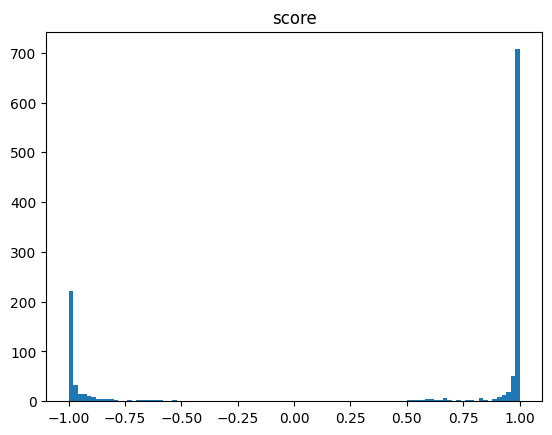

In [42]:
df = pd.DataFrame({"score": scores})
df.hist(bins=100, grid=False)

In [51]:
# seems that by setting a hard threshold to be 0.6, there is still probabilities to get non-neutral arguments.
chunks["polarity_confidence"] = scores
chunks[chunks["polarity_confidence"].abs() < 0.6]

,doc_id,chunk,chunk_rank,polarity_confidence
78,27,It looks a bit nicer on the picture .,0.981376,0.531209
93,31,Great look but .,0.967059,0.597937
220,65,It is very light and,0.962044,0.542399
303,92,I have pretty high arches and my calves always...,0.954312,-0.548907
319,98,this time my left shoe fit perfectly while the...,0.984235,-0.533466
359,115,Oops !,0.932829,-0.582753
399,132,not too sure how I like the fit on my foot,0.974043,0.591066
446,145,I would emphasize that if you do lifting as a ...,0.929342,0.534239
457,150,"feel like another layer of skin , not bulky or...",0.984721,0.588918
472,155,i would assume it would work fine for training...,0.955567,-0.575185


In [143]:
# textblob and other rule-based models give polarity scores, but not as accurate as pre-trained models based on benchmarks: https://pub.towardsai.net/sentiment-analysis-without-modeling-textblob-vs-vader-vs-flair-657b7af855f4.
from textblob import TextBlob
sent = "Today is Monday."
test = TextBlob(sent)
test.sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

In [144]:
# another pre-trained model based technique, but still doesn't give polarity scores as output.
from transformers import pipeline
senti_pipe = pipeline("sentiment-analysis")
senti_pipe(sent)

[{'label': 'POSITIVE', 'score': 0.9869946837425232}]

In [6]:
from orangecontrib.argument.miner.topic import merger

docs_topics = merger(docs, chunks["doc_id"], topics, topic_model.get_topics(), 10)
docs_topics.head()

,doc,topic,keyword,keyword_scores
0,I always get a half size up in my tennis shoes...,"[2, 10]","[half, ordered, wide, hard, narrow, order, doe...","[0.46720440366916216, 0.44428569020814185, 0.4..."
1,Put them on and walked 3 hours with no problem...,"[12, 19, 3, 5]","[week, favorite, runner, trail, miles, worn, l...","[0.7408391348156694, 0.6941245718589287, 0.666..."
2,excelente,[-1],[],[]
3,The shoes fit well in the arch area. They are ...,"[21, 10, 10, 24]","[wide, hard, narrow, does, wider, arch, toe, i...","[0.860751990580811, 0.8606794904768273, 0.8594..."
4,Tried them on in a store before buying online ...,"[13, 1, 4, 1, 9]","[loves, daughter, purchase, satisfied, couple,...","[0.9457426496928387, 0.8959407264399921, 0.890..."


In [ ]:
import copy
import numpy as np

full_topics = copy.deepcopy(topic_model.get_topics())
full_topics.pop(-1)

size = topic_model.top_n_words
keywords = []
keyword_scores = []
for i in full_topics:
    full_topic = full_topics[i]
    keywords += [w[0] for w in full_topic]
    keyword_scores.append([w[1] for w in full_topic]) 
keyword_scores = np.array(keyword_scores)

In [ ]:
# Merging topics by distribution may decrease the performance though
i = 7
result = keyword_scores * probs[i][:, np.newaxis]
df_doc_keyword = pd.DataFrame({
    "keyword": keywords, 
    "score": result.flatten()
})
df_doc_keyword = df_doc_keyword.groupby('keyword', as_index=False).max().sort_values(
    by="score", ascending=False).reset_index(drop=True)
print(docs.loc[i]['doc_id'])
print(docs.loc[i]['chunk'])
print("Topic %i" % topics[i])
for w in topic_model.get_topic(topics[i]):
    print(w)
df_doc_keyword.loc[0:9]

3
The shoes fit well in the arch area .
Topic 22
('arch', 0.8003347630850949)
('support', 0.6964831108214038)
('outside', 0.6054996839248983)
('decent', 0.549647492998692)
('kind', 0.5102821650788569)
('twinge', 0.4961268225201613)
('ripped', 0.4961268225201613)
('flimsy', 0.4961268225201613)
('higher', 0.4961268225201613)
('provided', 0.4961268225201613)


,keyword,score
0,grommets,0.016436
1,true,0.014916
2,laces,0.014784
3,photo,0.014784
4,dark,0.013420
5,left,0.012459
6,coming,0.012459
7,shown,0.012459
8,lighter,0.012113
9,squeaking,0.012113
